<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/1_22OLIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get -qq -y install fonts-nanum > /dev/null
print("✅ fonts-nanum 설치 완료. [런타임 → 런타임 다시 시작] 후 다음 셀 실행")


✅ fonts-nanum 설치 완료. [런타임 → 런타임 다시 시작] 후 다음 셀 실행


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 고정된 폰트: NanumBarunGothic


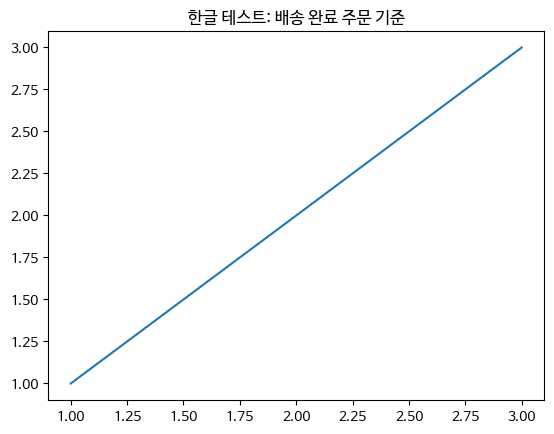

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 1) 폰트를 matplotlib에 '등록'
font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fm.fontManager.addfont(font_path)

# 2) 등록된 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 3) 기본 폰트로 '고정'
plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False

print("✅ 고정된 폰트:", font_name)

# 4) 한글 테스트(여기서 경고 없어야 정상)
plt.figure()
plt.title("한글 테스트: 배송 완료 주문 기준")
plt.plot([1, 2, 3], [1, 2, 3])
plt.show()


전체 데이터 통합 및 customer_fact 생성 코드

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import koreanize_matplotlib

# 1. 경로 설정 및 데이터 로드 (경로가 다를 경우 수정하세요)
BASE_PATH = '/content/drive/MyDrive/olist'
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

try:
    # 핵심 데이터 로드
    orders = pd.read_csv(f"{BASE_PATH}/olist_orders_dataset.csv", parse_dates=date_cols)
    order_items = pd.read_csv(f"{BASE_PATH}/olist_order_items_dataset.csv")
    customers = pd.read_csv(f"{BASE_PATH}/olist_customers_dataset.csv")
    products = pd.read_csv(f"{BASE_PATH}/olist_products_dataset.csv")
    translation = pd.read_csv(f"{BASE_PATH}/product_category_name_translation.csv")
    reviews = pd.read_csv(f"{BASE_PATH}/olist_order_reviews_dataset.csv")

    # 2. 전처리: 배송 완료 데이터 필터링 (delivered_orders 생성)
    delivered_orders = orders[orders['order_status'] == 'delivered'].copy()

    # 3. 데이터 마스터 조인
    df_master = (
        delivered_orders
        .merge(order_items, on='order_id')
        .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')
        .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
        .merge(translation, on='product_category_name', how='left')
    )

    # 4. 고객별 기본 정보 집계
    customer_fact = df_master.groupby('customer_unique_id').agg(
        first_purchase_at=('order_purchase_timestamp', 'min'),
        total_orders=('order_id', 'nunique'),
        total_revenue=('price', 'sum')
    ).reset_index()

    # 5. 첫 주문 정보 추출 (Activation 및 Referral용)
    first_orders = df_master.sort_values('order_purchase_timestamp').groupby('customer_unique_id').first().reset_index()
    first_orders['is_late'] = (first_orders['order_delivered_customer_date'] > first_orders['order_estimated_delivery_date']).astype(int)

    avg_reviews = reviews.groupby('order_id')['review_score'].mean().reset_index()
    first_orders = first_orders.merge(avg_reviews, on='order_id', how='left')

    # 6. 마스터 팩트 테이블 완성
    customer_fact = customer_fact.merge(
        first_orders[['customer_unique_id', 'is_late', 'review_score', 'product_category_name_english']],
        on='customer_unique_id'
    )

    # 7. AARRR 파생 변수 생성 (최종 관문)
    customer_fact['cohort_month'] = customer_fact['first_purchase_at'].dt.to_period('M')
    customer_fact['is_activated'] = ((customer_fact['is_late'] == 0) & (customer_fact['review_score'] >= 4)).astype(int)
    customer_fact['is_repurchaser'] = (customer_fact['total_orders'] >= 2).astype(int)
    customer_fact['is_promoter'] = (customer_fact['review_score'] == 5).astype(int)

    print(f"✅ 모든 데이터 로드 및 customer_fact 생성 완료!")
    print(f"📍 분석 대상 고객 수: {len(customer_fact):,}명")

except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. BASE_PATH 경로를 다시 확인해 주세요.")

customer_fact.head()

✅ 모든 데이터 로드 및 customer_fact 생성 완료!
📍 분석 대상 고객 수: 93,358명


,customer_unique_id,first_purchase_at,total_orders,total_revenue,is_late,review_score,product_category_name_english,cohort_month,is_activated,is_repurchaser,is_promoter
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,0,5.0,bed_bath_table,2018-05,1,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,0,4.0,health_beauty,2018-05,1,0,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,0,3.0,stationery,2017-03,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,0,4.0,telephony,2017-10,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,0,5.0,telephony,2017-11,1,0,1


Acquisition (유입): 성장 추이 및 핵심 카테고리

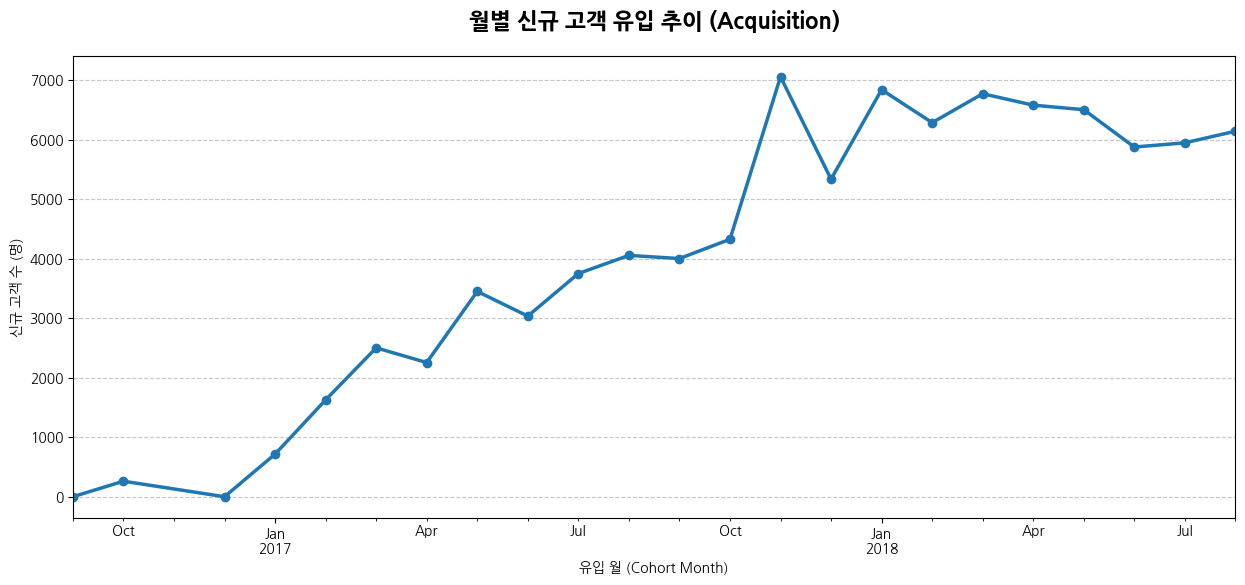

/tmp/ipython-input-665400150.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_inflow_cat.values, y=top_inflow_cat.index, palette='Blues_r')


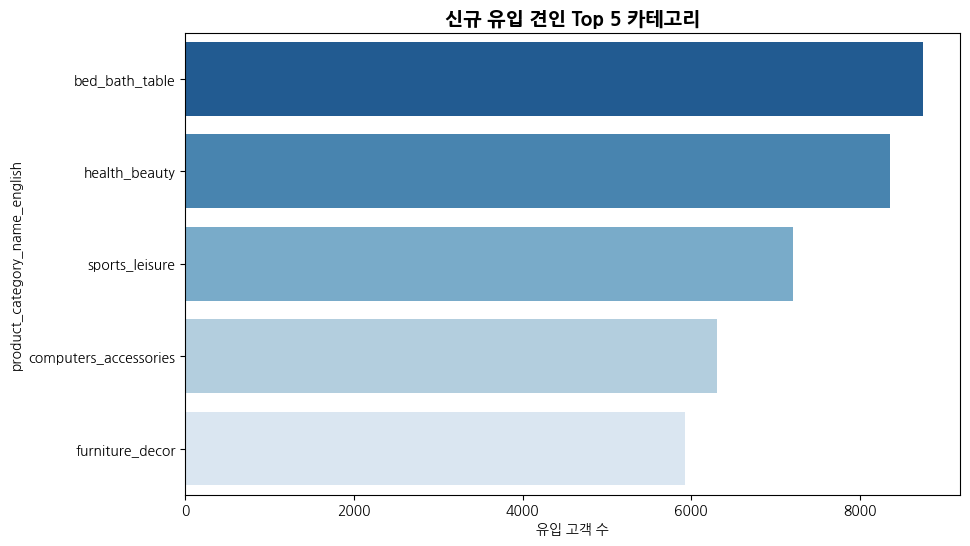

📍 전체 누적 유입 고객: 93,358명


In [5]:
# [Acquisition] 1. 월별 신규 유입 추이
plt.figure(figsize=(15, 6))
new_users = customer_fact.groupby('cohort_month').size()
new_users.plot(kind='line', marker='o', color='#1f77b4', linewidth=2.5)

plt.title('월별 신규 고객 유입 추이 (Acquisition)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('유입 월 (Cohort Month)')
plt.ylabel('신규 고객 수 (명)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# [Acquisition] 2. 유입을 견인하는 Top 5 카테고리
plt.figure(figsize=(10, 6))
top_inflow_cat = customer_fact['product_category_name_english'].value_counts().head(5)
sns.barplot(x=top_inflow_cat.values, y=top_inflow_cat.index, palette='Blues_r')
plt.title('신규 유입 견인 Top 5 카테고리', fontsize=14, fontweight='bold')
plt.xlabel('유입 고객 수')
plt.show()

print(f"📍 전체 누적 유입 고객: {len(customer_fact):,}명")

Activation (활성화): 첫 경험 만족도 진단

/tmp/ipython-input-1033024531.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Activation 실패', 'Activation 성공'], y=[100-activation_rate, activation_rate], palette='coolwarm', ax=ax[1])


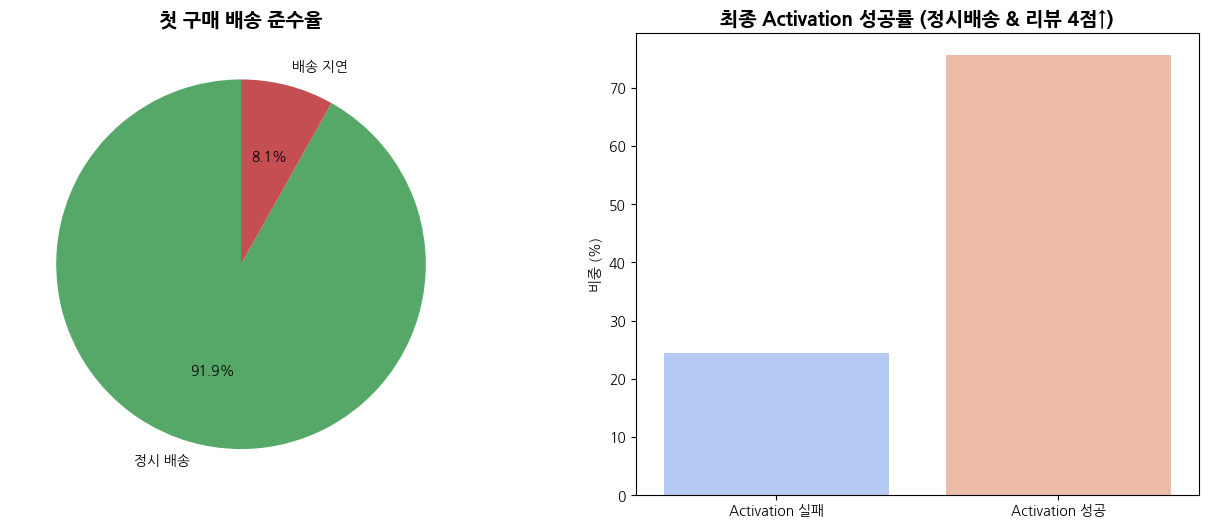

📍 성공적인 첫 경험을 한 고객 비중: 75.61%


In [6]:
# [Activation] 1. 배송 지연 여부 및 리뷰 점수 분포
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 배송 지연 비중
late_counts = customer_fact['is_late'].value_counts(normalize=True) * 100
ax[0].pie(late_counts, labels=['정시 배송', '배송 지연'], autopct='%.1f%%', startangle=90, colors=['#55a868', '#c44e52'])
ax[0].set_title('첫 구매 배송 준수율', fontsize=14, fontweight='bold')

# 활성화 성공률 (정시배송 & 고평점)
activation_rate = customer_fact['is_activated'].mean() * 100
sns.barplot(x=['Activation 실패', 'Activation 성공'], y=[100-activation_rate, activation_rate], palette='coolwarm', ax=ax[1])
ax[1].set_title('최종 Activation 성공률 (정시배송 & 리뷰 4점↑)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('비중 (%)')

plt.show()

print(f"📍 성공적인 첫 경험을 한 고객 비중: {activation_rate:.2f}%")

Retention (유지): 재구매 인과관계 증명

/tmp/ipython-input-2502289649.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=['실패 그룹', '성공 그룹'], y=retention_by_act.values, palette='viridis')


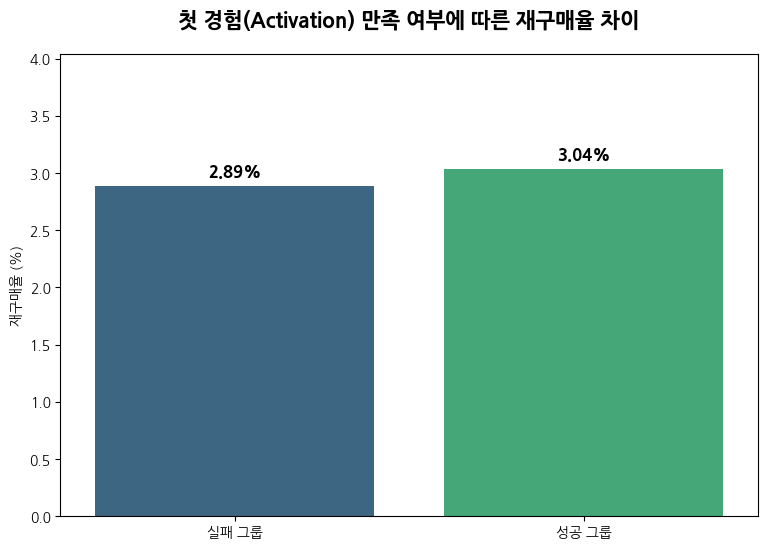

💡 근거: 첫 구매에서 만족(정시배송/고평점)한 그룹의 리텐션이 실패 그룹보다 얼마나 높은지 확인하세요.


In [7]:
# [Retention] Activation 성공 여부에 따른 재구매율 차이
retention_by_act = customer_fact.groupby('is_activated')['is_repurchaser'].mean() * 100

plt.figure(figsize=(9, 6))
bars = sns.barplot(x=['실패 그룹', '성공 그룹'], y=retention_by_act.values, palette='viridis')

plt.title('첫 경험(Activation) 만족 여부에 따른 재구매율 차이', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('재구매율 (%)')

# 그래프 위에 수치 표시
for p in bars.patches:
    bars.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', fontweight='bold', xytext=(0, 10),
                textcoords='offset points')

plt.ylim(0, retention_by_act.max() + 1)
plt.show()

print("💡 근거: 첫 구매에서 만족(정시배송/고평점)한 그룹의 리텐션이 실패 그룹보다 얼마나 높은지 확인하세요.")

Revenue (수익): 리텐션의 경제적 가치 증명

/tmp/ipython-input-3955550135.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['1회 구매 고객', '재구매 고객'], y=ltv_analysis.values, palette='GnBu', ax=ax[0])


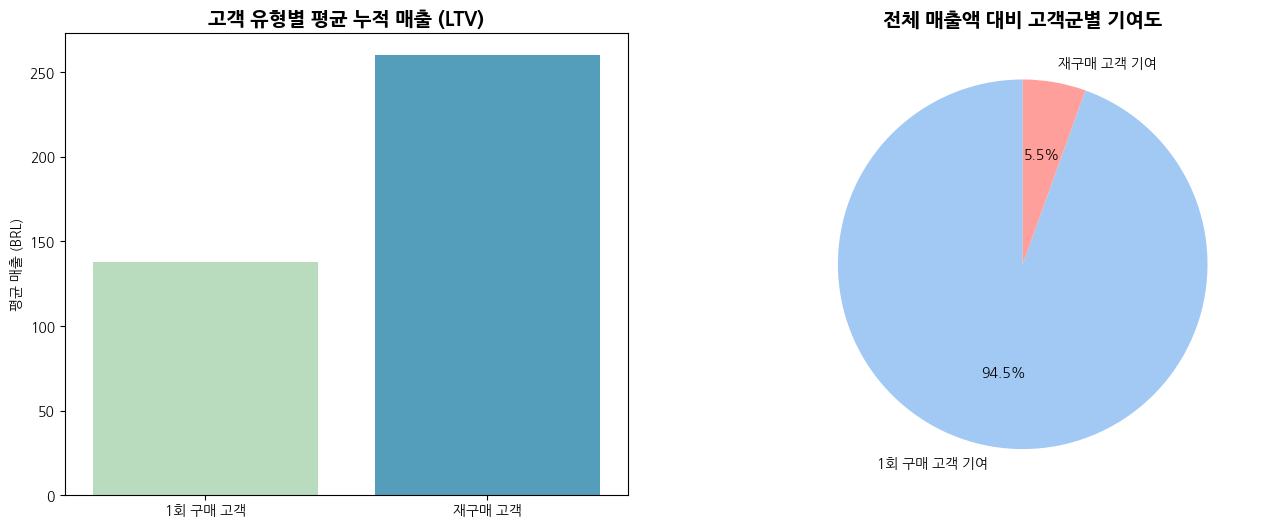

📍 재구매 고객의 평균 LTV: 260.05 BRL (1회 고객 대비 1.9배)


In [8]:
# [Revenue] 고객 유형별 누적 매출(LTV) 및 매출 기여도
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. 1인당 평균 누적 매출액
ltv_analysis = customer_fact.groupby('is_repurchaser')['total_revenue'].mean()
sns.barplot(x=['1회 구매 고객', '재구매 고객'], y=ltv_analysis.values, palette='GnBu', ax=ax[0])
ax[0].set_title('고객 유형별 평균 누적 매출 (LTV)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('평균 매출 (BRL)')

# 2. 전체 매출 기여도 비중
total_rev_share = customer_fact.groupby('is_repurchaser')['total_revenue'].sum()
ax[1].pie(total_rev_share, labels=['1회 구매 고객 기여', '재구매 고객 기여'], autopct='%.1f%%', startangle=90, colors=['#a1c9f4', '#ff9f9b'])
ax[1].set_title('전체 매출액 대비 고객군별 기여도', fontsize=14, fontweight='bold')

plt.show()

print(f"📍 재구매 고객의 평균 LTV: {ltv_analysis[1]:.2f} BRL (1회 고객 대비 {ltv_analysis[1]/ltv_analysis[0]:.1f}배)")

Referral (추천): 강력 추천 고객군 분석

/tmp/ipython-input-1739387515.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_promoter_cat.values, y=top_promoter_cat.index, palette='spring')


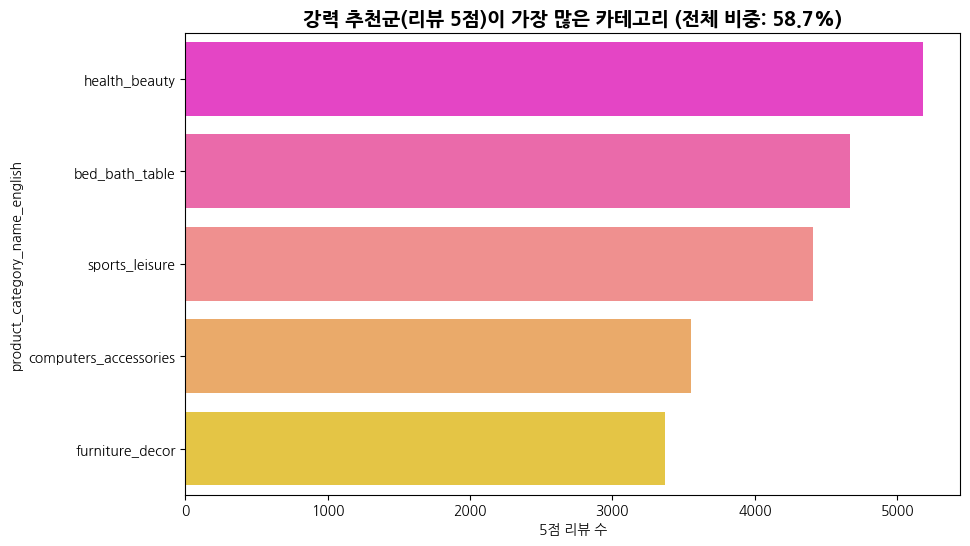

In [9]:
# [Referral] 추천 지표: 5점 리뷰(Promoter) 비중 및 카테고리
promoter_rate = customer_fact['is_promoter'].mean() * 100

plt.figure(figsize=(10, 6))
top_promoter_cat = customer_fact[customer_fact['is_promoter']==1]['product_category_name_english'].value_counts().head(5)
sns.barplot(x=top_promoter_cat.values, y=top_promoter_cat.index, palette='spring')

plt.title(f'강력 추천군(리뷰 5점)이 가장 많은 카테고리 (전체 비중: {promoter_rate:.1f}%)', fontsize=14, fontweight='bold')
plt.xlabel('5점 리뷰 수')
plt.show()